<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Целевое значение метрики качества *F1* не меньше 0.75. 

**План выполнения проекта**

1. Загрузить и подготовить данные.
2. Обучить разные модели.
3. Выбрать лучшую модель и протестировать ее.
4. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [3]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


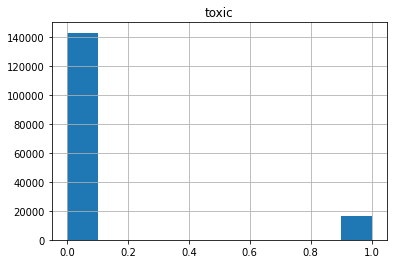

In [4]:
data.hist();

В целевом признаке есть сильный дисбаланс, что необходимо учесть в обучении модели

In [5]:
#функция для очистки текста
def clear_text(text):
    new_text = re.sub(r'[^a-zA-Z ]', ' ', text)
    new_text = new_text.split()
    return " ".join(new_text)

In [31]:
#для ускорения работы кода оставим сэмпл в 20% от исходного датасета.
#в финальной версии прогоняем алгоритм на полной выборке
#data = data.sample(frac=0.2, random_state=12345)

In [8]:
data = data.reset_index(drop=True)

#очистим текст написанной функцией
for i in range(len(data['text'])):
    data.loc[i, 'text'] = clear_text(data.loc[i, 'text'])

data

,text,toxic
0,Explanation Why the edits made under my userna...,0
1,D aww He matches this background colour I m se...,0
2,Hey man I m really not trying to edit war It s...,0
3,More I can t make any real suggestions on impr...,0
4,You sir are my hero Any chance you remember wh...,0
...,...,...
159287,And for the second time of asking when your vi...,0
159288,You should be ashamed of yourself That is a ho...,0
159289,Spitzer Umm theres no actual article for prost...,0
159290,And it looks like it was actually you who put ...,0


In [9]:
features = data.drop('toxic', axis=1)
target = data['toxic']

features_train, features_vt, target_train, target_vt = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_vt, target_vt, test_size=0.5, random_state=12345, stratify=target_vt)

In [10]:
features_train = features_train.reset_index(drop=True)
features_valid = features_valid.reset_index(drop=True)
features_test = features_test.reset_index(drop=True)

target_train = target_train.reset_index(drop=True)
target_valid = target_valid.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)

In [11]:
#функция лемматизации с POS
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [12]:
%%time

#лемматизируем тексты
lemmatizer = WordNetLemmatizer()
for i in range(len(features_train['text'])):
    features_train.loc[i, 'text'] = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(features_train.loc[i, 'text'])]
    features_train.loc[i, 'text'] = " ".join(features_train.loc[i, 'text'])

CPU times: user 14min 37s, sys: 1min 19s, total: 15min 57s
Wall time: 15min 57s


In [13]:
%%time

for i in range(len(features_valid['text'])):
    features_valid.loc[i, 'text'] = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(features_valid.loc[i, 'text'])]
    features_valid.loc[i, 'text'] = " ".join(features_valid.loc[i, 'text'])

CPU times: user 1min 49s, sys: 9.89 s, total: 1min 59s
Wall time: 1min 59s


In [14]:
%%time

for i in range(len(features_test['text'])):
    features_test.loc[i, 'text'] = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(features_test.loc[i, 'text'])]
    features_test.loc[i, 'text'] = " ".join(features_test.loc[i, 'text'])

CPU times: user 1min 54s, sys: 10.3 s, total: 2min 5s
Wall time: 2min 5s


In [15]:
#проверка промежуточного результата
features_train

,text
0,I don t mean to intrude but I have notice the ...
1,God or whoever whatever I now decree you the c...
2,Can we keep this neat and sequential We have a...
3,Here s what you say May Rama block expires Jun...
4,Sir Giggsy have often say that he like to keep...
...,...
127428,Indeed BigDunc that page rightly say that para...
127429,I m not try to make a point or anything except...
127430,Forgive my cruddy formattingI m still relative...
127431,Talk Grasshopper Scouts I move your comment fr...


In [16]:
corpus = features_train['text']
corpus_1 = features_valid['text']
corpus_2 = features_test['text']

In [17]:
stop_words = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

tf_idf_train = count_tf_idf.fit_transform(corpus)

tf_idf_train.shape

(127433, 140007)

In [18]:
tf_idf_train

<127433x140007 sparse matrix of type '<class 'numpy.float64'>'
	with 3366829 stored elements in Compressed Sparse Row format>

In [19]:
tf_idf_valid = count_tf_idf.transform(corpus_1)
tf_idf_valid.shape

(15929, 140007)

In [20]:
tf_idf_test = count_tf_idf.transform(corpus_2)
tf_idf_test.shape

(15930, 140007)

## Обучение

In [21]:
# Логистическая регрессия с подбором параметров GridSearch
paramsLR = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
modelLR = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')

gridLR = GridSearchCV(modelLR, paramsLR, cv = 2, scoring='f1')
 
gridLR.fit(tf_idf_train, target_train)

F1LR = gridLR.best_score_

print('Лучшие параметры:', gridLR.best_params_)             
print('F1 LR:', F1LR)

Лучшие параметры: {'C': 10.0, 'penalty': 'l2'}
F1 LR: 0.7555635034735373


In [28]:
#зафиксируем лучшие параметры: params = {'C': 10.0, 'penalty': 'l2'}
model = LogisticRegression(random_state=12345, solver='liblinear', C=10, penalty='l2')
model.fit(tf_idf_train, target_train)
pred = model.predict(tf_idf_valid)
f1_linear = f1_score(target_valid, pred)

print('F1 LogisticRegression:', f1_linear)

F1 LogisticRegression: 0.7766323024054982


In [23]:
# Дерево решений
best_depth = 0
best_f1_tree = 0
for depth in range(1, 30, 2):
    model = DecisionTreeClassifier(random_state=12345, class_weight='balanced', max_depth=depth)
    model.fit(tf_idf_train, target_train)
    pred = model.predict(tf_idf_valid)
    score = f1_score(target_valid, pred)
    if score > best_f1_tree:
        best_depth = depth
        best_f1_tree = score

print('F1 best DecisionTree:', best_f1_tree)
print('Best depth:', best_depth)

F1 best DecisionTree: 0.6211096075778078
Best depth: 29


In [24]:
%%time

# CatBoost
model = CatBoostClassifier(random_state=12345, iterations=450)
model.fit(tf_idf_train, target_train)
pred = model.predict(tf_idf_valid)
f1_cat = f1_score(target_valid, pred)

print('F1 CatBoost:', f1_cat)

Learning rate set to 0.169783
0:	learn: 0.5264917	total: 3.09s	remaining: 23m 5s
1:	learn: 0.4223121	total: 5.39s	remaining: 20m 6s
2:	learn: 0.3548286	total: 7.75s	remaining: 19m 14s
3:	learn: 0.3131636	total: 10.1s	remaining: 18m 47s
4:	learn: 0.2849264	total: 12.5s	remaining: 18m 33s
5:	learn: 0.2661239	total: 14.8s	remaining: 18m 18s
6:	learn: 0.2529375	total: 17.2s	remaining: 18m 9s
7:	learn: 0.2414086	total: 19.6s	remaining: 18m
8:	learn: 0.2348309	total: 21.9s	remaining: 17m 51s
9:	learn: 0.2292537	total: 24.3s	remaining: 17m 48s
10:	learn: 0.2247297	total: 26.6s	remaining: 17m 40s
11:	learn: 0.2213757	total: 28.9s	remaining: 17m 35s
12:	learn: 0.2184088	total: 31.2s	remaining: 17m 29s
13:	learn: 0.2146055	total: 33.7s	remaining: 17m 30s
14:	learn: 0.2123230	total: 36s	remaining: 17m 24s
15:	learn: 0.2100489	total: 38.3s	remaining: 17m 19s
16:	learn: 0.2078115	total: 40.6s	remaining: 17m 15s
17:	learn: 0.2053162	total: 43.1s	remaining: 17m 14s
18:	learn: 0.2035971	total: 45.5s	r

In [29]:
models_comp = pd.DataFrame({'model': ['DecisionTree', 'LogisticRegression', 'CatBoost'],
              'f1 score': [best_f1_tree, f1_linear, f1_cat]})
display(models_comp)

,model,f1 score
0,DecisionTree,0.621110
1,LogisticRegression,0.776632
2,CatBoost,0.742940


Среди трех моделей лучший результат показывает логистическая регрессия с F1=0.78.
Протестируем ее.

## Тестирование

In [30]:
model = LogisticRegression(random_state=12345, solver='liblinear', C=10, penalty='l2')
model.fit(tf_idf_train, target_train)
pred = model.predict(tf_idf_test)
f1_linear = f1_score(target_test, pred)

print('F1 LogisticRegression:', f1_linear)

F1 LogisticRegression: 0.7810691181477697


## Выводы

Для задачи по выявлению токсичных комментариев проделана большая работа:
1. Очищен и лемматизирован массив текстов для обучения\тестирования
2. Тексты переведены в формат векторов
3. На подготовленных данных обучено несколько моделей.
4. Выбрана и протестирована лучшая модель.

Лучше всего для данной задачи подошла модель линейной регрессии - она показала наиболее высокое значение F1-score=0.78 как на валидационной, так и на тестовой выборках. В качестве приятного бонуса  - она еще и самая быстрая среди рассмотренных.

Гиперпараметры модели выбраны при помощи GridSearchCV, в результате модель справилась даже с несбалансированными классами в целевом признаке.

Могу сделать вывод, что ап/даунсемплинг в данном случае бесполезен, т.к. первый не улучшает метрики, но сильно увеличивает затраты времени на выполнение кода, а второй ведет к урезанию обучающей выборки, что пагубно сказывается на качестве модели.